# 02 — BG Forecast LSTM Training

Loads preprocessed sequences from notebook 01, trains a multi-horizon LSTM, evaluates in mg/dL, and exports the model + scaler to `app_backend/models/`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import joblib, shutil, os

c:\Users\wei cong\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.10) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


## 1. Load Preprocessed Data

In [2]:
data = np.load('processed/bg_forecast_sequences.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val,   y_val   = data['X_val'],   data['y_val']
X_test,  y_test  = data['X_test'],  data['y_test']

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Target shape (3 horizons): {y_train.shape[1]}")

Train: (55939, 12, 8), Val: (15473, 12, 8), Test: (14826, 12, 8)
Target shape (3 horizons): 3


## 2. Build LSTM Model

In [3]:
n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
n_outputs   = y_train.shape[1]  # 3 horizons

model = keras.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_outputs)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867 (81.51 KB)

 Trainable params: 20,867 (81.51 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Train with Callbacks

In [4]:
os.makedirs('checkpoints', exist_ok=True)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/bg_forecast_best.keras',
        monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 15191.6846 - mae: 98.6662 - val_loss: 1124.9677 - val_mae: 23.8562 - learning_rate: 0.0010
Epoch 2/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1418.7740 - mae: 27.4633 - val_loss: 1054.1499 - val_mae: 23.3105 - learning_rate: 0.0010
Epoch 3/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1336.3048 - mae: 26.5078 - val_loss: 1041.9452 - val_mae: 23.3079 - learning_rate: 0.0010
Epoch 4/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1288.8678 - mae: 26.0062 - val_loss: 1002.0276 - val_mae: 22.7769 - learning_rate: 0.0010
Epoch 5/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1257.8521 - mae: 25.7131 - val_loss: 1027.7299 - val_mae: 23.0982 - learning_rate: 0.0010
Epoch 6/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1228.0239 - mae: 25.4132 - val_loss: 1033.8285 - val_mae: 23.0137 - learning_rate: 0.0010
Epoch 7/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1228.4501 - mae: 25.3307 - val_l

## 4. Training Curves

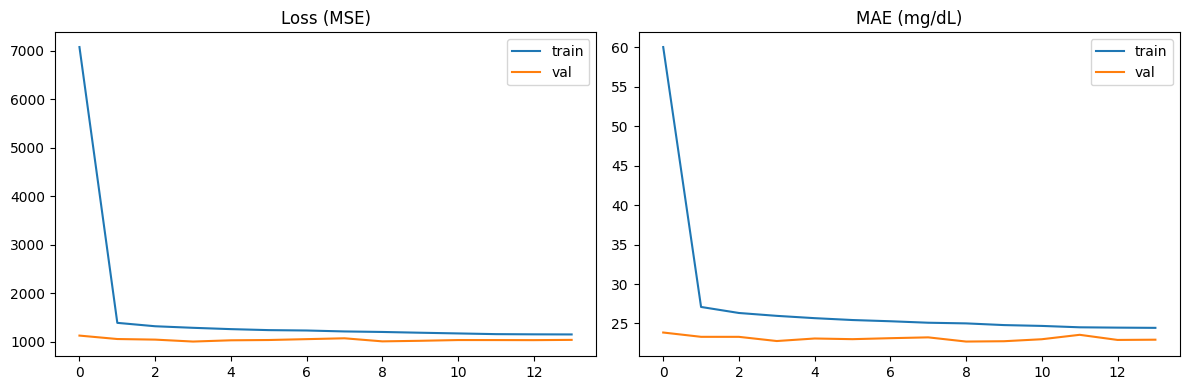

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], label='train')
axes[0].plot(history.history['val_loss'], label='val')
axes[0].set_title('Loss (MSE)'); axes[0].legend()
axes[1].plot(history.history['mae'], label='train')
axes[1].plot(history.history['val_mae'], label='val')
axes[1].set_title('MAE (mg/dL)'); axes[1].legend()
plt.tight_layout(); plt.show()

## 5. Evaluate on Test Set (mg/dL)

In [7]:
y_pred = model.predict(X_test)

horizon_labels = ['30 min', '60 min', '90 min']
for i, label in enumerate(horizon_labels):
    mae  = np.mean(np.abs(y_test[:, i] - y_pred[:, i]))
    rmse = np.sqrt(np.mean((y_test[:, i] - y_pred[:, i])**2))
    print(f"{label}  —  MAE: {mae:.2f} mg/dL,  RMSE: {rmse:.2f} mg/dL")

464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
30 min  —  MAE: 17.19 mg/dL,  RMSE: 24.33 mg/dL
60 min  —  MAE: 27.71 mg/dL,  RMSE: 37.32 mg/dL
90 min  —  MAE: 36.10 mg/dL,  RMSE: 47.28 mg/dL


## 6. Visualize Predictions vs Actual

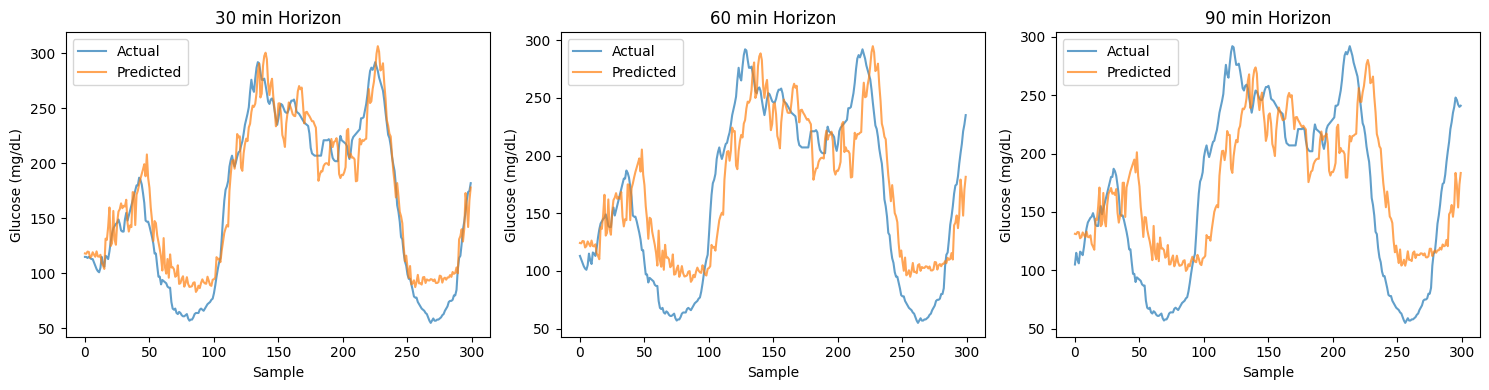

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sample = slice(0, 300)
for i, (ax, label) in enumerate(zip(axes, horizon_labels)):
    ax.plot(y_test[sample, i], label='Actual', alpha=0.7)
    ax.plot(y_pred[sample, i], label='Predicted', alpha=0.7)
    ax.set_title(f'{label} Horizon'); ax.legend()
    ax.set_xlabel('Sample'); ax.set_ylabel('Glucose (mg/dL)')
plt.tight_layout(); plt.show()

## 7. Export Model & Scaler to Backend

In [9]:
export_dir = '../app_backend/models'
os.makedirs(export_dir, exist_ok=True)

model.save(os.path.join(export_dir, 'bg_forecast_lstm.keras'))
shutil.copy('processed/bg_forecast_scaler.joblib',
            os.path.join(export_dir, 'bg_forecast_scaler.joblib'))
shutil.copy('processed/bg_forecast_meta.json',
            os.path.join(export_dir, 'bg_forecast_meta.json'))

print('Exported to app_backend/models/:')
for f in os.listdir(export_dir):
    print(f'  {f}')

Exported to app_backend/models/:
  best_random_forest_model.pkl
  bg_forecast_lstm.keras
  bg_forecast_meta.json
  bg_forecast_scaler.joblib
  feature_names.pkl
  table_classifier.keras
  temp.py
